In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#%cd drive/MyDrive/Github/master_thesis
%cd drive/MyDrive/GitHub/master-thesis
from clustering.utils import *

/content/drive/MyDrive/GitHub/master-thesis


# Preprocessing

In [14]:
beh_cols = get_behaviour_cols()
df_pca_input = get_preprocessed_data(impute=True, impute_cols=beh_cols, start='2020-07-31', end='2021-02-02')

In [15]:
# Train Test Split
end_train = '2020-12-01'
df_pca_input_train = df_pca_input[(df_pca_input.date < end_train)]
max(df_pca_input_train.date)

Timestamp('2020-11-30 00:00:00')

In [16]:
scaler = MinMaxScaler()
pca_input_train = scaler.fit_transform(df_pca_input_train[beh_cols].to_numpy())
pca_input = scaler.fit_transform(df_pca_input[beh_cols].to_numpy())
pca_input.shape

(48933, 34)

# PCA

In [17]:
pca = PCA(whiten=True)
pca.fit(pca_input_train)
x_pca = pca.transform(pca_input)
df_pca = pd.DataFrame(x_pca)
for column in df_pca.columns:
  df_pca.rename(columns={column: 'PC_'+str(column)}, inplace=True)
df_pca.head()

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,...,PC_24,PC_25,PC_26,PC_27,PC_28,PC_29,PC_30,PC_31,PC_32,PC_33
0,0.531813,-1.636320,1.542158,-1.023375,1.072374,1.390508,0.529888,0.793541,-0.702190,-0.441820,...,-4.266736,-2.172528,-2.546023,0.685243,-1.128198,1.014528,-3.943620,1.650719,0.578005,0.465011
1,2.189312,-0.770928,2.709443,2.844339,0.837373,0.627478,-0.159490,1.498554,-0.282332,2.133845,...,0.095044,-0.498831,-1.131213,-0.982680,1.353966,-2.029520,1.011834,-1.020420,1.477903,0.625532
2,-1.136979,-0.916749,-0.659621,0.396104,1.268714,1.813853,-1.482695,-1.572988,-0.333627,-0.233608,...,-2.488033,2.234233,-1.184444,-0.761565,-0.150954,-0.575282,-1.131534,-0.183729,-0.097998,0.155330
3,-1.317027,0.587581,-1.392977,0.991426,0.829220,-0.199629,-0.328054,0.789160,1.636139,-0.943760,...,0.056697,0.427739,-0.438729,0.502415,0.207794,-0.164334,0.041784,0.049904,0.030789,-0.014783
4,-1.630848,0.430191,0.923452,-0.009860,-0.634810,0.631976,-0.852655,-0.169432,0.603593,2.938310,...,0.030889,0.311225,0.060112,0.717700,0.163786,0.151060,0.349660,-0.060003,0.127320,-0.875754


# Evaluate Results

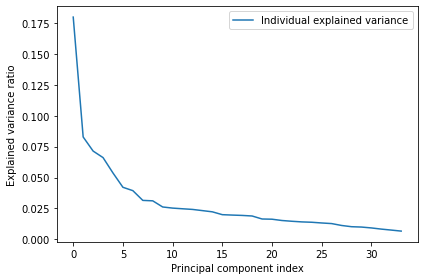

In [18]:
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.plot(range(0,len(exp_var_pca)), exp_var_pca, label='Individual explained variance')
#plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.rcParams["figure.figsize"] = (8, 6)
plt.show()

In [19]:
num_comp_avg = (exp_var_pca > exp_var_pca.mean()).sum()
explained_variance = cum_sum_eigenvalues[num_comp_avg-1]
print(f'{num_comp_avg} Komponenten sind größer als der Durchschnitt und erklären damit {np.round(explained_variance * 100, 2)}% der Varianz in den Daten.')

9 Komponenten sind größer als der Durchschnitt und erklären damit 59.81% der Varianz in den Daten.


In [20]:
cum_sum_eigenvalues

array([0.17995926, 0.26281088, 0.33424721, 0.400391  , 0.45407466,
       0.49616595, 0.53553018, 0.56700558, 0.59812553, 0.6242626 ,
       0.64949162, 0.67417281, 0.69833447, 0.72152709, 0.74373685,
       0.7636408 , 0.78321869, 0.80251507, 0.82135158, 0.83776022,
       0.85399156, 0.86917062, 0.88373135, 0.89778103, 0.91153778,
       0.92472095, 0.93741029, 0.94857204, 0.95873022, 0.96860381,
       0.97776629, 0.98598044, 0.99340339, 1.        ])

Die Dimensionen sollen soweit reduziert werden, dass noch 80% der Varianz benötigt werden.

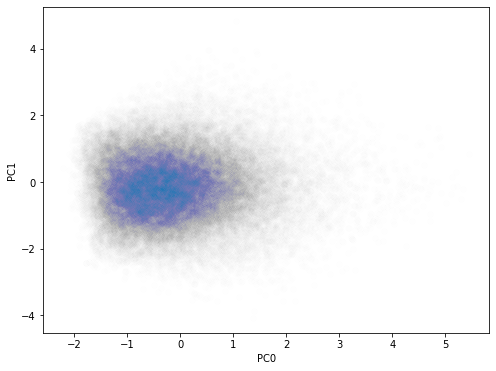

In [21]:
plt.scatter(x=df_pca['PC_0'], y=df_pca['PC_1'], alpha=0.005)
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.show()

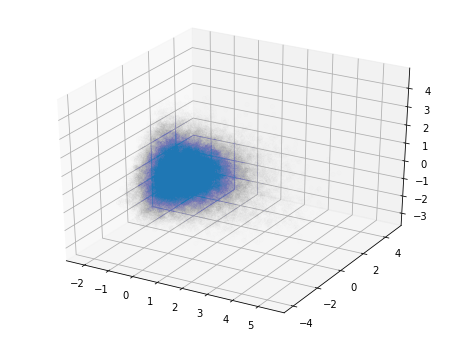

In [22]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df_pca['PC_0'], df_pca['PC_1'], df_pca['PC_2'], alpha=0.005)

# Write Data

In [24]:
col_names = df_pca.iloc[:,:num_comp_avg].columns.tolist()
subset_drop = col_names + ['date']
df_pca_write = pd.concat([df_pca.iloc[:,:num_comp_avg].copy(), df_pca_input], axis=1)
df_pca_write.dropna(subset=subset_drop, inplace=True)
df_pca_write.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46074 entries, 2 to 48932
Data columns (total 89 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   PC_0                                           46074 non-null  float64       
 1   PC_1                                           46074 non-null  float64       
 2   PC_2                                           46074 non-null  float64       
 3   PC_3                                           46074 non-null  float64       
 4   PC_4                                           46074 non-null  float64       
 5   PC_5                                           46074 non-null  float64       
 6   PC_6                                           46074 non-null  float64       
 7   PC_7                                           46074 non-null  float64       
 8   PC_8                                           46074 non

In [ ]:
df_pca_write.to_csv('data/preprocessing/dim_reduction/220422_pca_data.csv', index=False)

# Evaluate PCA Components

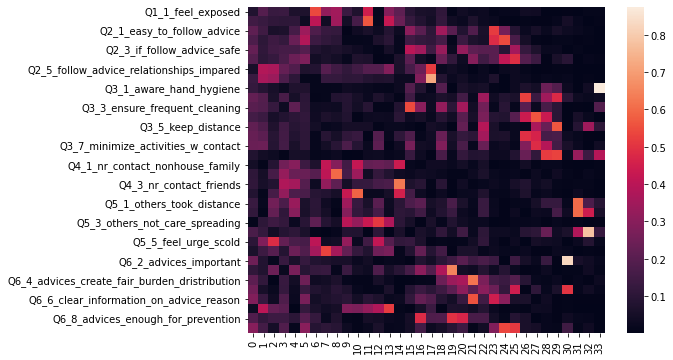

In [25]:
import seaborn as sns
df_components = pd.DataFrame(pca.components_, columns=beh_cols).transpose()
df_components = df_components.apply(lambda x: np.abs(x))
sns.heatmap(df_components) # .iloc[:,:nr_pc_80]

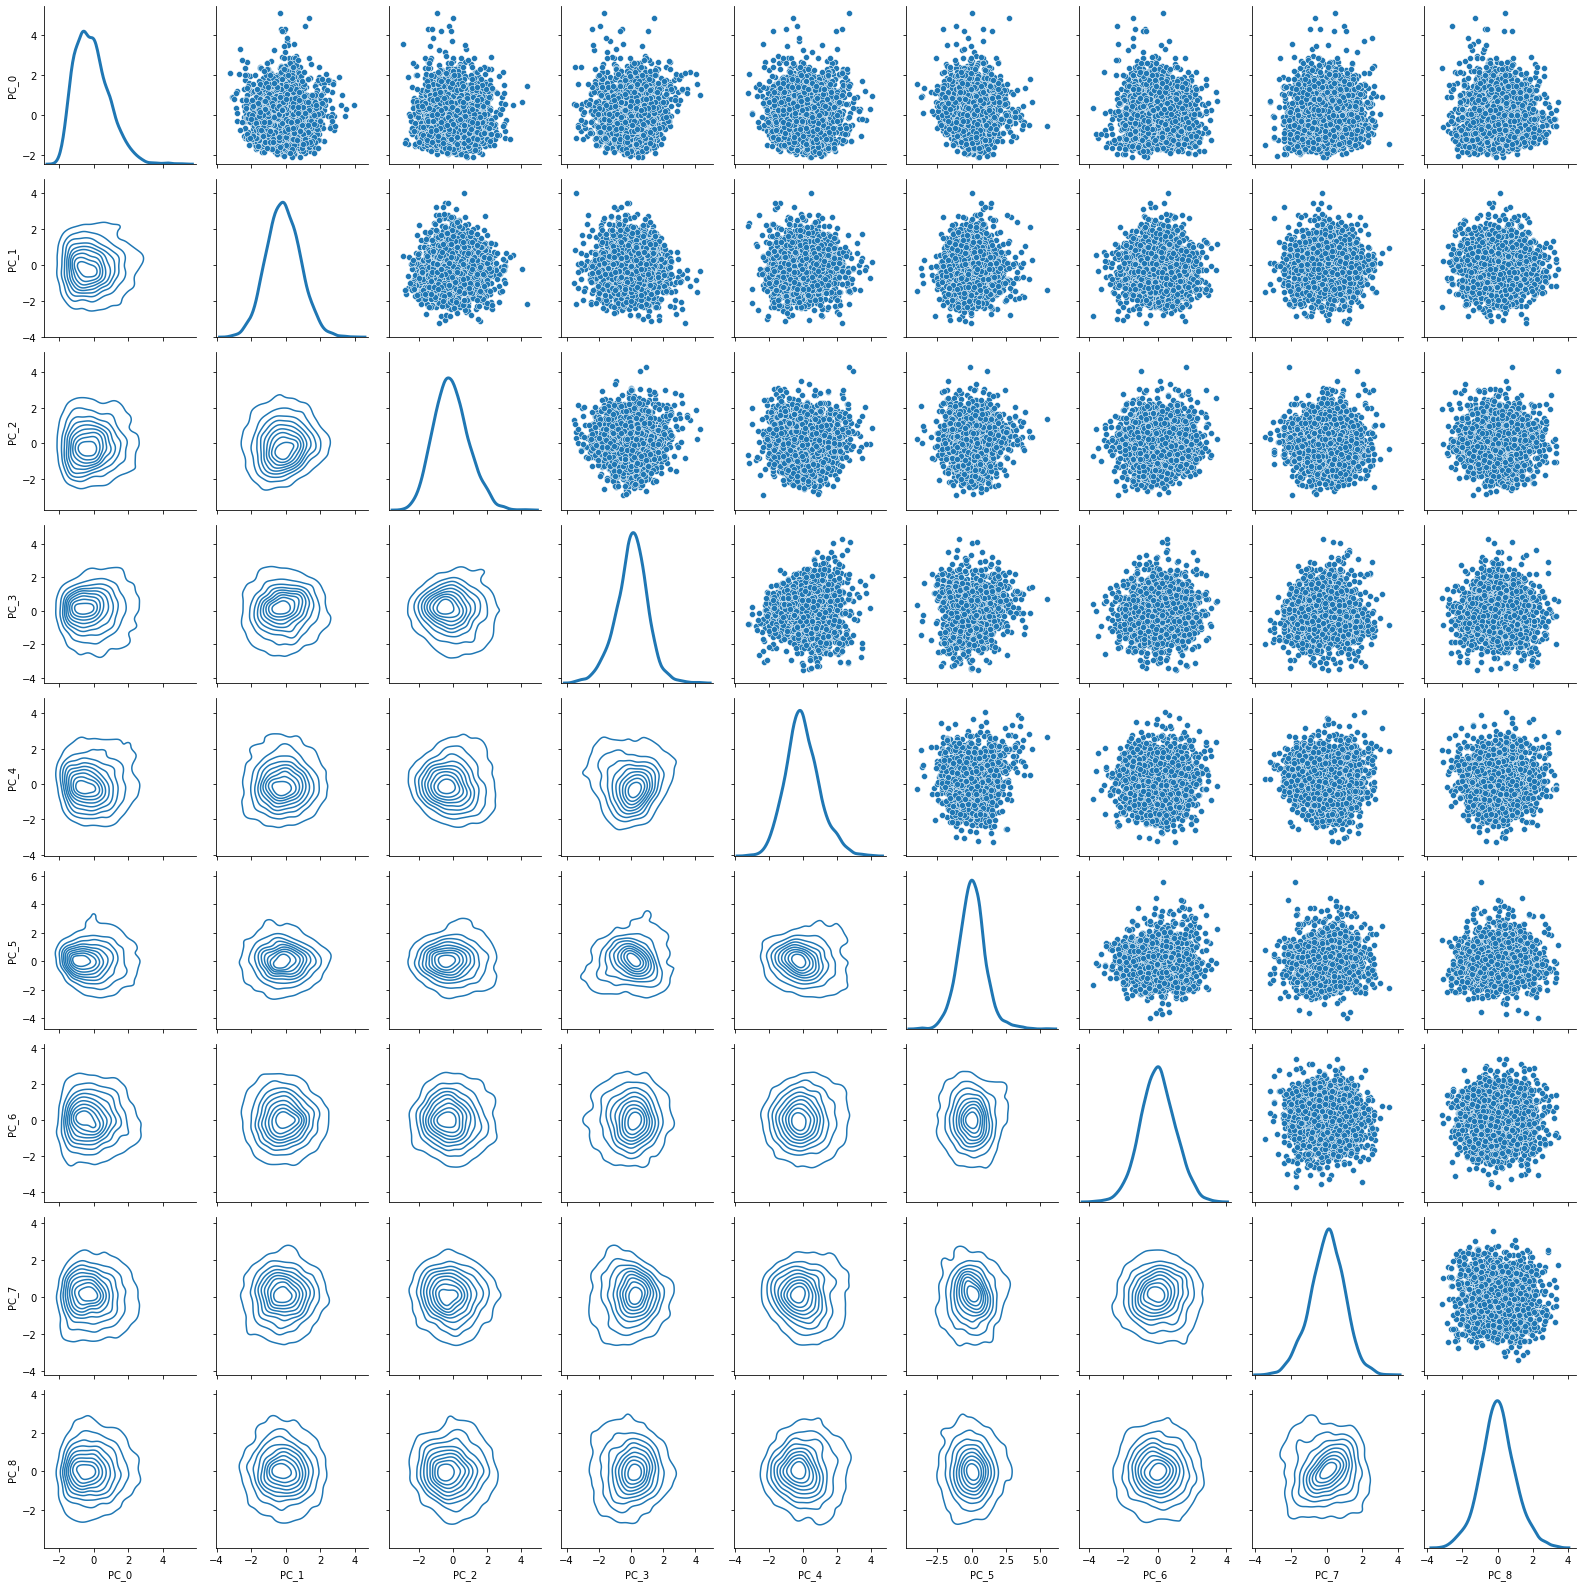

In [27]:
start = '2020-12-01'
end = '2020-12-14'
df_plot = df_pca_write.copy()
df_plot.date = pd.to_datetime(df_plot.date)
in_range = (df_plot.date > start) & (df_plot.date < end)
df_plot = df_plot[in_range]
df_plot = df_plot[col_names]
g = sns.PairGrid(data=df_plot)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

In [26]:
import plotly.express as px
df_lineplot = df_pca_write[subset_drop].groupby('date').mean().reset_index()
df_lineplot[col_names] = df_lineplot[col_names].rolling(14).mean()
px.line(df_lineplot, x='date', y=col_names)